In [65]:
testar_ate = 700

In [66]:
import json

def load_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

questoes = load_jsonl('inputs/questoes.jsonl')

questao_por_id = {q['ID_QUESTAO']:q for q in questoes}

In [67]:
import pandas as pd

df = pd.read_json("outputs/4 - respostas_llms/respostas_llms.jsonl", lines=True)

# Filtra apenas os que já tem dados
df = df[df['ID_QUESTAO'] <= testar_ate]

# Converte ID_QUESTAO para string
df["ID_QUESTAO"] = df["ID_QUESTAO"].astype(str)

# Adiciona a resposta correta:
df["RESPOSTA_CORRETA"] = df["ID_QUESTAO"].map(
    lambda id_: questao_por_id[id_]["RESPOSTA"]
)

# Verifica se acertou
df["ACERTOU"] = df["RESPOSTA_CORRETA"] == df["RESPOSTA_LLM"]

In [68]:
import numpy as np

# Agora agrupa e vê o percentual de acerto em cada caso.

# Observação: Se o MODELO_RAG == 'Gold', NUM_CHUNKS deve ser desconsiderado,
# pois ele apenas mostra o total de chunks da base de dados (e que foram enviados ao LLM)
df["NUM_CHUNKS_AGRUP"] = np.where(
    df["MODELO_RAG"] == "Gold",
    "Todos",          # valor fixo para não diferenciar
    df["NUM_CHUNKS"]    # usa o valor real
)

df_resultado = (
    df
    .groupby(
        ["MODELO_LLM", "MODELO_RAG", "TIPO_PESQUISA_CHUNKS", "NUM_CHUNKS_AGRUP"],
        as_index=False
    )["ACERTOU"]
    .mean()
)

df_resultado

,MODELO_LLM,MODELO_RAG,TIPO_PESQUISA_CHUNKS,NUM_CHUNKS_AGRUP,ACERTOU
0,deepseek-chat,,,0,0.877143
1,deepseek-chat,Gold,apenas_art,Todos,0.932857
2,deepseek-chat,Gold,todos_chunks,Todos,0.951429
3,deepseek-chat,bm25,apenas_art,1,0.927143
4,deepseek-chat,bm25,apenas_art,2,0.934286
5,deepseek-chat,bm25,apenas_art,3,0.937143
6,deepseek-chat,bm25,todos_chunks,1,0.921429
7,deepseek-chat,bm25,todos_chunks,2,0.930000
8,deepseek-chat,bm25,todos_chunks,3,0.931429
9,deepseek-chat,text-embedding-3-large,apenas_art,1,0.921429


In [69]:
import matplotlib.pyplot as plt
import numpy as np


In [78]:
COLOR_MAP = {
    "bm25": "tab:blue",
    "text-embedding-3-large": "tab:orange",
}

LINESTYLE_MAP = {
    "todos_chunks": "-",
    "apenas_art": "--",
}

BASELINE_STYLE = {
    "linestyle": ":",
    "linewidth": 2,
}

GOLD_STYLE = {
    "linestyle": "-.",
    "linewidth": 2,
}


In [79]:
def plot_rag_summary_per_llm(df_resultado):
    for llm, df_llm in df_resultado.groupby("MODELO_LLM"):
        plt.figure(figsize=(9, 6))

        # --------------------------------------------------
        # 1) Baseline (MODELO_RAG == "")
        # --------------------------------------------------
        baseline_vals = df_llm[df_llm["MODELO_RAG"] == ""]["ACERTOU"]

        if not baseline_vals.empty:
            baseline = baseline_vals.mean()
            plt.axhline(
                baseline,
                color="black",
                label="Sem chunks",
                **BASELINE_STYLE
            )

        # --------------------------------------------------
        # 2) Gold (um por tipo de pesquisa)
        # --------------------------------------------------
        df_gold = df_llm[df_llm["MODELO_RAG"] == "Gold"]

        for tipo, g in df_gold.groupby("TIPO_PESQUISA_CHUNKS"):
            gold_val = g["ACERTOU"].mean()

            plt.axhline(
                gold_val,
                color="gray",
                linestyle=LINESTYLE_MAP.get(tipo, "-."),
                linewidth=2,
                label=f"Gold | {tipo}"
            )

        # --------------------------------------------------
        # 3) Curvas BM25 / Embeddings
        # --------------------------------------------------
        df_rag = df_llm[
            (df_llm["MODELO_RAG"] != "") &
            (df_llm["MODELO_RAG"] != "Gold")
        ]

        for (rag, tipo), g in df_rag.groupby(
            ["MODELO_RAG", "TIPO_PESQUISA_CHUNKS"]
        ):
            g = g.sort_values("NUM_CHUNKS_AGRUP")

            plt.plot(
                g["NUM_CHUNKS_AGRUP"],
                g["ACERTOU"],
                marker="o",
                color=COLOR_MAP.get(rag, None),
                linestyle=LINESTYLE_MAP.get(tipo, "-"),
                label=f"{rag} | {tipo}"
            )

        # --------------------------------------------------
        # 4) Acabamento
        # --------------------------------------------------
        plt.title(f"Desempenho de RAG — {llm}")
        plt.xlabel("Número de chunks")
        plt.ylabel("Acurácia")
        plt.ylim(.85, 1)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


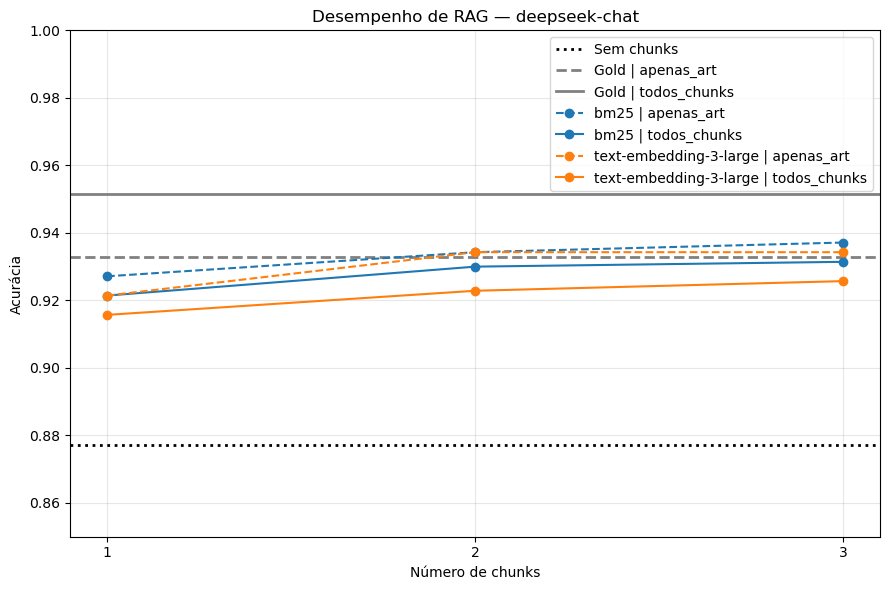

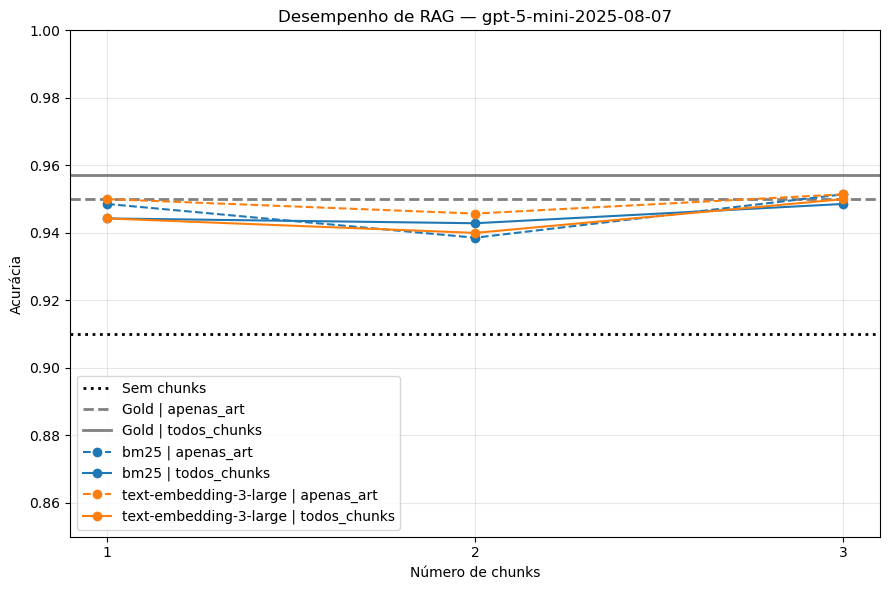

In [80]:
plot_rag_summary_per_llm(df_resultado)

In [73]:
NOME_ARQUIVO_RESULTADOS_PESQUISAS_TODOS_CHUNKS = 'outputs/3 - resultados_pesquisas/resultados_pesquisas_todos_chunks.pickle.gz'
NOME_ARQUIVO_RESULTADOS_PESQUISAS_APENAS_ART = 'outputs/3 - resultados_pesquisas/resultados_pesquisas_apenas_art.pickle.gz'

In [74]:
# Para abrir os arquivos depois:
def load_pickle_gzip(path):
    import pickle
    import gzip
    with gzip.open(path, 'rb') as f:
        return pickle.load(f)

def load_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

chunks_pesquisa = load_jsonl('inputs/chunks_pesquisa.jsonl')
chunk_por_urn = {c['URN']:c for c in chunks_pesquisa}

resultados_pesquisas_todos_chunks = load_pickle_gzip(NOME_ARQUIVO_RESULTADOS_PESQUISAS_TODOS_CHUNKS)
resultados_pesquisas_apenas_art = load_pickle_gzip(NOME_ARQUIVO_RESULTADOS_PESQUISAS_APENAS_ART)

In [75]:
MAX_CHUNKS = 3

tamanho_chunks_todos_chunks = {}
tamanho_chunks_apenas_art = {}

for _, resultados_para_questao in resultados_pesquisas_todos_chunks.items():
    for modelo in resultados_para_questao.keys():
        urns_retornados = resultados_para_questao[modelo]['urn'] # é uma lista

        # inicializa o modelo se ainda não existir
        if modelo not in tamanho_chunks_todos_chunks:
            tamanho_chunks_todos_chunks[modelo] = {
                n_chunks: [] for n_chunks in range(1, MAX_CHUNKS+1)
            }
            
        for n_chunks in range(1, MAX_CHUNKS+1):
            tamanho_chunks = sum(len(chunk_por_urn[urn]['TEXTO']) for urn in urns_retornados[:n_chunks])
            tamanho_chunks_todos_chunks[modelo][n_chunks].append(tamanho_chunks)
            
        
for _, resultados_para_questao in resultados_pesquisas_apenas_art.items():
    for modelo in resultados_para_questao.keys():
        urns_retornados = resultados_para_questao[modelo]['urn'] # é uma lista

        # inicializa o modelo se ainda não existir
        if modelo not in tamanho_chunks_apenas_art:
            tamanho_chunks_apenas_art[modelo] = {
                n_chunks: [] for n_chunks in range(1, MAX_CHUNKS+1)
            }
            
        for n_chunks in range(1, MAX_CHUNKS+1):
            tamanho_chunks = sum(len(chunk_por_urn[urn]['TEXTO']) for urn in urns_retornados[:n_chunks])
            tamanho_chunks_apenas_art[modelo][n_chunks].append(tamanho_chunks)
        


In [76]:
import statistics

print(f'************* TODOS CHUNKS *************')

for modelo in tamanho_chunks_todos_chunks.keys():
    print(f'------------- {modelo} -------------')
    for n_chunks in range(1, MAX_CHUNKS+1):
        print(f'\t{n_chunks}: {statistics.mean(tamanho_chunks_todos_chunks[modelo][n_chunks])}')

print(f'************* APENAS ARTIGOS *************')

for modelo in tamanho_chunks_apenas_art.keys():
    print(f'------------- {modelo} -------------')
    for n_chunks in range(1, MAX_CHUNKS+1):
        print(f'\t{n_chunks}: {statistics.mean(tamanho_chunks_apenas_art[modelo][n_chunks])}')



************* TODOS CHUNKS *************
------------- bm25 -------------
	1: 2389.3542857142857
	2: 5188.914285714286
	3: 8378.23142857143
------------- text-embedding-3-large -------------
	1: 1622.82
	2: 3375.03
	3: 5131.144285714286
************* APENAS ARTIGOS *************
------------- bm25 -------------
	1: 2332.0385714285712
	2: 4538.55
	3: 6702.484285714286
------------- text-embedding-3-large -------------
	1: 2157.6457142857143
	2: 4048.305714285714
	3: 5854.815714285714
